# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [3]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3          4
v22     18211
v24         5
v30         8
v31         4
v47        10
v52        13
v56       123
v66         3
v71         9
v74         3
v75         4
v79        18
v91         8
v107        8
v110        3
v112       23
v113       37
v125       91
dtype: int64


In [5]:
# Создаем дамми-переменные для категорий
dummy = pd.get_dummies(data[cat_feat], columns=cat_feat)

# Заменяем пропуски на медиану
train_median = data[num_feat].median()
X = pd.concat([data[num_feat].fillna(train_median),
                     data[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'), dummy], axis=1)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.3, random_state=0, stratify=Y2)

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
# X = pd.concat([data[num_feat].fillna(-999), dummy], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 362 entries, v1 to v112_nan
dtypes: float64(108), int64(4), int8(127), uint8(123)
memory usage: 124.9 MB


In [6]:
from sklearn.preprocessing import LabelEncoder
Y = data.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

##### Обучаем случайный лес

In [8]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)   

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

In [10]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train RF:
ROC AUC: 0.7404
Test RF:
ROC AUC: 0.7389


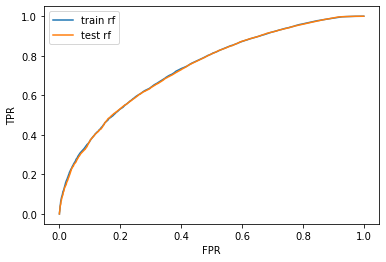

In [11]:
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]

print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')
plt.legend();

#### Определим важность признаков и выведем для наглядности первые 15

In [79]:
imp = pd.Series(clf_rf.feature_importances_)
imp2 = imp.sort_values(ascending=False).iloc[:15]
imp2

43     0.538262
285    0.100859
336    0.073097
284    0.046389
256    0.041460
109    0.032918
262    0.030253
337    0.027786
303    0.025622
283    0.013740
95     0.008969
306    0.007293
8      0.006855
28     0.006383
246    0.005854
dtype: float64

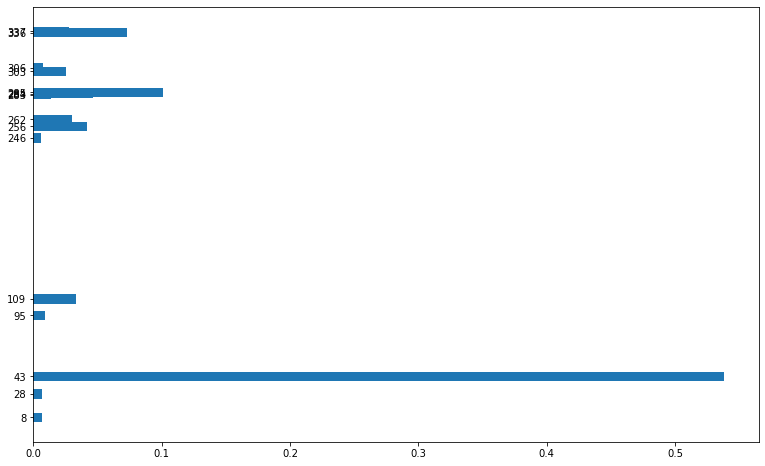

In [80]:
fig, axes = plt.subplots(figsize=(13,8))
axes.barh(imp2.index, imp2, height=8)
ysticks = imp2.index
axes.set_yticks (ysticks) 

#### Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

##### Готовим признаки

In [23]:
from sklearn.preprocessing import StandardScaler

In [81]:
X2_train = X_train.iloc[:, imp2.index]
X2_test = X_test.iloc[:, imp2.index]
X2_test

,v50,v66_C,v110_A,v66_B,v31_A,v129,v47_C,v110_B,v79_B,v66_A,v114,v79_E,v10,v34,v24_D
69453,1.074022,0,0,0,0,2,1,1,1,1,7.829207,0,6.542669,5.789226,0
111776,4.755337,0,0,0,0,1,1,1,1,1,14.487948,0,5.754924,8.353168,0
44152,1.398283,0,1,0,1,0,0,0,0,1,15.268617,0,1.575492,7.446043,0
85374,0.765901,1,0,0,0,1,1,1,1,0,16.755220,0,1.641138,9.193682,0
23839,0.865673,0,0,1,0,2,1,1,0,0,13.198889,0,3.916849,7.345717,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31279,4.450151,0,1,0,1,0,0,0,0,1,15.127501,0,2.363239,6.863878,0
44202,0.331596,0,1,1,1,0,0,0,0,0,12.061450,0,0.743983,4.672836,0
29175,0.758565,0,0,1,0,2,1,1,0,0,7.151597,0,4.442014,4.260022,1
95443,0.852469,0,0,1,1,0,1,1,0,0,6.898787,1,1.816192,2.456050,0


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

##### Обучаем классификаторы: Логистическая регрессия, Дерево решений, k-ближайших соседей, Случайный лес 

##### Объединяем классификаторы в ансамбль и обучаем стекинг

In [82]:
estimators = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=42))),
    ('dt', DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=42)),
    ('kn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski'))),
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42))    
     ]

In [83]:
classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [84]:
classifier.fit(X2_train, y_train)

StackingClassifier(estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=0.001,
                                                                    random_state=42))])),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=1,
                                                       random_state=42)),
                               ('kn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=1))])

In [85]:
classifier.named_estimators_['lr']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, random_state=42))])

LR
ROC AUC: 0.7287
DT
ROC AUC: 0.6330
KN
ROC AUC: 0.5822
RF
ROC AUC: 0.6831
STACK
ROC AUC: 0.7342


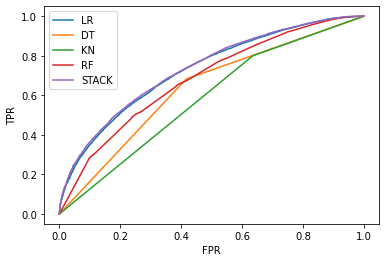

In [86]:
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X2_test)[:,1]
y_pred_proba_dt = classifier.named_estimators_['dt'].predict_proba(X2_test)[:,1]
y_pred_proba_kn = classifier.named_estimators_['kn'].predict_proba(X2_test)[:,1]
y_pred_proba_rf = classifier.named_estimators_['rf'].predict_proba(X2_test)[:,1]
y_pred_proba = classifier.predict_proba(X2_test)[:,1]
print("LR")
show_auc(y_test, y_pred_proba_lr, 'LR')
print("DT")
show_auc(y_test, y_pred_proba_dt, 'DT')
print("KN")
show_auc(y_test, y_pred_proba_kn, 'KN')
print("RF")
show_auc(y_test, y_pred_proba_rf, 'RF')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()

##### Стек дал лучшую оценку